In [38]:
# we load the things!

from ngsolve import *
#from netgen.csg import * 
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
from netgen.occ import *
#from netgen.meshing import *

import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np

import pandas as pd

In [39]:
# some helper functions
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [40]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of a vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of a scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed a scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of a vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [41]:
# Functions for plotting, linear regression fit line for convergence

def reference_line_func(h_values, scaling_factor, slope):

    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):

    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [42]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for a tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(a, b, c):
    s = (a + b + c) / 2  
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

def circumradius_2D(a, b, c):
    area = triangle_area(a, b, c)
    return a * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            a = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(a, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

In [43]:
def createGeometry(hmax):

    wp = WorkPlane()

    wp.MoveTo(0, 0)      
    wp.LineTo(0, 0.5)
    wp.LineTo(-0.5, 0.5)  
    wp.LineTo(-0.5, -0.5)
    wp.LineTo(0.5, -0.5)
    wp.LineTo(0.5, 0)
    wp.LineTo(0, 0)
    wp.Close()

    shape = wp.Face()
    geometry = OCCGeometry(shape, dim=2)
    reEntrantCornerGeo = Mesh(geometry.GenerateMesh(maxh=hmax))
    
    return reEntrantCornerGeo

In [44]:
# Hodge Laplace for 1-forms function

def hodgeLaplace1Forms(mesh,
                       u_m = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if u_m is None:
        u_m = CF((0,0))

    H_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl) space
    H_1 = H1(mesh, order=order)     # For 0-forms, H1 space
    fes = H_curl * H_1
    (u, p), (v, q) = fes.TnT()

    curlu = curl(u)                                 # curl(u)
    curlu_times_v = CF((-curlu*v[1],curlu*v[0])) # curl(u) x u'
    curlv = curl(v)                               # curl(u')
    curlv_times_u = CF((-curlv*u[1],curlv*u[0])) # curl(u') x u

    B = BilinearForm(fes)
    
    B += u * grad(q) * dx
    B += - p * q * dx
    
    B +=  grad(p) * v * dx
    B +=  curl(u) * curl(v) * dx

    n = specialcf.normal(mesh.dim)
    h = specialcf.mesh_size
    t = specialcf.tangential(mesh.dim)

    #Here we have 2 different but equivalent formulations for the product gamma_n(u) * gamma_parallel(v)

    #gamma_p_v = v*t
    #gamma_p_u = u*t
    #gamma_n_u = - curl(u)
    #gamma_n_v = - curl(v)

    gamma_p_u = u - n*(u*n)
    gamma_p_v = v - n*(v*n)
    gamma_n_u = -curl(u)*t
    gamma_n_v = -curl(v)*t

    B += gamma_n_u * gamma_p_v * ds(skeleton=True)
    B += gamma_p_u * gamma_n_v * ds(skeleton=True)
    B += C_w/h * u.Trace() * v.Trace() * ds

    #B += curlu_times_v*n *ds (skeleton = True)
    #B += curlv_times_u*n * ds(skeleton = True)

    f = CF(GCurl(GCurl(u_m)) - GGrad(GDiv(u_m)))

    rhs = LinearForm(fes)
    rhs += f * v * dx

    #gamma_p_u_m = CF((-n[1]*u_m[0] + n[0]*u_m[1]))
    gamma_p_u_m = u_m - n*(u_m*n) 
    
    rhs +=  (C_w / h) * gamma_p_u_m * gamma_p_v * ds(skeleton=True)
    rhs +=  gamma_p_u_m * gamma_n_v * ds(skeleton=True)
    rhs +=  u_m * n * q * ds(skeleton=True)
    
    with TaskManager(): 
        B.Assemble()
        rhs.Assemble()
        sol = GridFunction(fes)

        res = rhs.vec-B.mat * sol.vec
        inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
        
        sol.vec.data += inv * res


    gf_u , gf_p = sol.components

    curl_u = CF(Grad(gf_u)[1,0] - Grad(gf_u)[0,1])
    grad_p = grad(gf_p)

    curl_u_m = CF(GCurl(u_m))
    p_m = - CF(GDiv(u_m))
    grad_p_m = CF(GGrad(p_m))

    L2_error_u = sqrt(Integrate((gf_u - u_m)**2, mesh))
    L2_error_curl_u = sqrt(Integrate((curl_u - curl_u_m)**2, mesh))
    L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
    L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

    # gf_gamma_p_u = BoundaryFromVolumeCF(CF(gf_u[1]*n[0] - gf_u[0]*n[1]))
    # gf_gamma_p_u_m = BoundaryFromVolumeCF(CF(u_m[1]*n[0] - u_m[0]*n[1]))

    # gf_gamma_n_u = BoundaryFromVolumeCF(curl_u)
    # gf_gamma_n_u_m = BoundaryFromVolumeCF(curl_u_m)
    
    # gf_u_n = BoundaryFromVolumeCF(CF(gf_u * n))
    # gf_u_n_m = BoundaryFromVolumeCF(CF(u_m * n))

    gf_gamma_p_u = CF(gf_u[1]*n[0] - gf_u[0]*n[1])
    gf_gamma_p_u_m = CF(u_m[1]*n[0] - u_m[0]*n[1])

    gf_gamma_n_u = BoundaryFromVolumeCF(curl_u)
    gf_gamma_n_u_m = BoundaryFromVolumeCF(curl_u_m)
    
    gf_u_n = CF(gf_u * n)
    gf_u_n_m = CF(u_m * n)

    L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_u_n = sqrt(Integrate((gf_u_n - gf_u_n_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_p_gamma = sqrt(Integrate((gf_p - p_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))

    # terms for the hashtag error!
    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

    HT_error_gamma_p = Integrate(h_avg**(-1)*(gf_gamma_p_u - gf_gamma_p_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_gamma_n = Integrate(h_avg*(gf_gamma_n_u - gf_gamma_n_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_u = sqrt(L2_error_u**2 + L2_error_curl_u**2 + HT_error_gamma_p + HT_error_gamma_n)
    #HT_error_u = HT_error_gamma_n

    return fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_gamma, HT_error_u, sqrt(HT_error_gamma_n), sqrt(HT_error_gamma_p)

In [45]:
# definition of manufactured solutions

#omega_m_sinusoids_2D = CF((-sin(pi*x)*cos(pi*y), cos(pi*x)*sin(pi*y))) # This one vanishes!
#omega_m_sinusoids_2D = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y))) # This one vanishes!
omega_m_sinusoids_2D = CF((cos(x)*sin(y), sin(x)*cos(y))) # This is a manufactured solution that DOESNT vanish on the boundary!


# A = 0.05  # Pulse Amplitude
# sigma_pulse = 0.05  # Pulse Width
# r0 = (0.5, 0.5)  # Pulse Center
# n_pulse = (1, 0)  # Pulse Direction

# omega_m_gauss_2D = CF((
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[0],
#     A * exp(-((x - r0[0])**2 + (y - r0[1])**2) / (2 * sigma_pulse**2)) * n_pulse[1]
# ))


In [46]:
# # Convergence study data generation for 2D

# saveBigCSV = True

# refinementVals = 4
# hmax_init = 0.5

# maxh_values = [] 

# Cw_vals = logspace_custom_decades(10**0, 100, 8)
# #Cw_vals = np.linspace(2,12,20)

# orders = [1, 2, 3, 4, 5]

# all_results = []

# for refinement_step in range(refinementVals):
    
#     #print(f"hmax after refinement {refinement_step}: {h_max_eval}")
#     if refinement_step == 0:
#         mesh = createGeometry(hmax_init)
#         mesh.Refine()
#     else:
#         mesh.Refine()

#     h_max_eval = calc_hmax(mesh)
#     maxh_values.append(h_max_eval)
#     print("doing h_max: ", h_max_eval)

#     for order_cw in orders:
#         results_cw = []
#         print("doing order: ", order_cw)

#         for C_w in Cw_vals:
#             u_m = omega_m_sinusoids_2D

#             ndof, res, L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u, HT_error_gamma_n, HT_error_gamma_p = hodgeLaplace1Forms(
#                 mesh, u_m=u_m, order=order_cw, C_w=C_w
#             )

#             row_dict = {
#                 'order': order_cw,
#                 'hmax': h_max_eval,
#                 'C_w': C_w,
#                 'ndof': ndof,
#                 'res': res,
#                 'L2_error_u': L2_error_u,
#                 'L2_error_curl_u': L2_error_curl_u,
#                 'L2_error_p': L2_error_p,
#                 'L2_error_grad_p': L2_error_grad_p,
#                 'L2_error_gamma_p_u': L2_error_gamma_p_u,
#                 'L2_error_u_n': L2_error_u_n,
#                 'L2_error_p_Gamma': L2_error_p_Gamma,
#                 'HT_error_u': HT_error_u,
#                 'HT_error_gamma_n': HT_error_gamma_n,
#                 'HT_error_gamma_p': HT_error_gamma_p
#             }
#             all_results.append(row_dict)

# df_all_results = pd.DataFrame(all_results)

# if (saveBigCSV == True):
#     df_all_results.to_csv("all_2D_1forms_simulation_results.csv", index=False)
    

In [47]:
def hodgeLaplace1FormsTest(mesh,
                       u_m = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if u_m is None:
        u_m = CF((0,0))

    H_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl) space
    H_1 = H1(mesh, order=order)     # For 0-forms, H1 space
    fes = H_curl * H_1
    (u, p), (v, q) = fes.TnT()

    n = specialcf.normal(mesh.dim)
    h = specialcf.mesh_size
    t = specialcf.tangential(mesh.dim)
    f = CF(GCurl(GCurl(u_m)) - GGrad(GDiv(u_m)))

    curlu = curl(u)                                 # curl(u)
    curlv = curl(v)                               # curl(u')

    gamma_p_u = u - n*(u*n)
    gamma_p_v = v - n*(v*n)
    
    gamma_n_u = CF((curlu*n[1], -curlu*n[0]))
    gamma_n_v = CF((curlv*n[1], -curlv*n[0]))

    B, F  = BilinearForm(fes), LinearForm(fes)

    B +=  grad(p) * v * dx
    B +=  curl(u) * curl(v) * dx
    
    B += u * grad(q) * dx
    B += - p * q * dx

    B += gamma_n_u * v * ds(skeleton=True)
    B += u * gamma_n_v * ds(skeleton=True)
    B += (C_w/h) * (u*t) * (v*t) * ds(skeleton=True)

    F += f * v * dx
    
    F +=  (C_w / h) * (u_m*t) * (v*t) * ds(skeleton=True)

    F +=  u_m * gamma_n_v * ds(skeleton=True)
    F +=  u_m * n * q.Trace() * ds(definedon=mesh.Boundaries(".*"))
    
    with TaskManager(): 
        B.Assemble()
        F.Assemble()
        plt.plot(F.vec.data)
        sol = GridFunction(fes)
        res = F.vec-B.mat * sol.vec
        inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    
    sol.vec.data += inv * res
    
    gf_u , gf_p = sol.components

    curl_u = CF(Grad(gf_u)[1,0] - Grad(gf_u)[0,1])
    grad_p = grad(gf_p)

    curl_u_m = CF(GCurl(u_m))
    p_m = - CF(GDiv(u_m))
    grad_p_m = CF(GGrad(p_m))

    L2_error_u = sqrt(Integrate((gf_u - u_m)**2, mesh))
    L2_error_curl_u = sqrt(Integrate((curl_u - curl_u_m)**2, mesh))
    L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
    L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

    gf_gamma_p_u = CF(gf_u[1]*n[0] - gf_u[0]*n[1])
    gf_gamma_p_u_m = CF(u_m[1]*n[0] - u_m[0]*n[1])

    gf_gamma_n_u = BoundaryFromVolumeCF(curl_u)
    gf_gamma_n_u_m = BoundaryFromVolumeCF(curl_u_m)
    
    gf_u_n = CF(gf_u * n)
    gf_u_n_m = CF(u_m * n)

    L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_u_n = sqrt(Integrate((gf_u_n - gf_u_n_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))
    L2_error_p_gamma = sqrt(Integrate((gf_p - p_m)**2*ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh))

    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

    HT_error_gamma_p = Integrate(h_avg**(-1)*(gf_gamma_p_u - gf_gamma_p_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_gamma_n = Integrate(h_avg*(gf_gamma_n_u - gf_gamma_n_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_u = sqrt(L2_error_u**2 + L2_error_curl_u**2 + HT_error_gamma_p + HT_error_gamma_n)

    return gf_u, gf_p, fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_gamma, HT_error_u, sqrt(HT_error_gamma_n), sqrt(HT_error_gamma_p)

L2 Error u  3.5858738069467105e-07


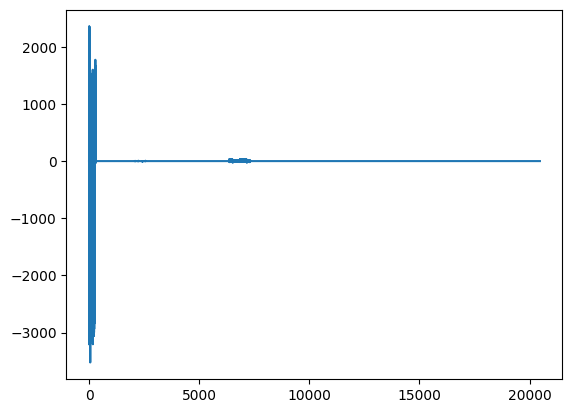

In [48]:
g = CF((2*cos(x)*sin(y), sin(x)*cos(y)))
mesh = createGeometry(0.036)
testResults = hodgeLaplace1FormsTest(mesh, g, 3, 100)
gf_u = testResults[0]
print("L2 Error u ", testResults[4])

In [50]:
Draw(g, mesh)
max = 0
for i in range(0,len(gf_u.vec)):
    if gf_u.vec.data[i] > max:
        max = gf_u.vec.data[i]

print(max)
#print(gf_u.vec.data)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

0.03652214664091739
